In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import json
import urllib.request

In [4]:
# Load a pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
#Check if it identifies the image to a given class such as "duck"
# Step 1: Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),       # Resize to 256x256
    transforms.CenterCrop(224),   # Crop to 224x224 (expected by ResNet)
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize(         # Normalize to ImageNet standards
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Step 3: Load your image
img_path = "german_shepard_dog.jpeg"  # Replace with your image path
input_image = Image.open(img_path).convert("RGB")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Step 4: Perform inference
with torch.no_grad():
    output = model(input_batch)

# Step 5: Download ImageNet class labels
# Open and load the JSON data into a Python variable
file_path = "imagenet-simple-labels.json"
with open(file_path, 'r') as json_file:
    labels = json.load(json_file)

# Step 6: Get the predicted label
_, predicted_idx = torch.max(output, 1)
print(predicted_idx)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label: {predicted_label}")

tensor([235])
Predicted label: German Shepherd Dog


In [17]:
# Define the patch size and initialize the patch with random values
patch_size = (50, 50)
patch = torch.rand((3, *patch_size), requires_grad=True)
patch

tensor([[[0.5506, 0.9154, 0.6046,  ..., 0.7789, 0.6850, 0.2459],
         [0.4551, 0.1410, 0.8032,  ..., 0.0820, 0.2519, 0.8468],
         [0.7368, 0.3419, 0.9020,  ..., 0.7994, 0.1082, 0.1894],
         ...,
         [0.7817, 0.8890, 0.3749,  ..., 0.8319, 0.7280, 0.9920],
         [0.8644, 0.2000, 0.7773,  ..., 0.9103, 0.4470, 0.1114],
         [0.5530, 0.4320, 0.5697,  ..., 0.6387, 0.3565, 0.0978]],

        [[0.5632, 0.6561, 0.5916,  ..., 0.2593, 0.3087, 0.1787],
         [0.2392, 0.3857, 0.4428,  ..., 0.5677, 0.2689, 0.0384],
         [0.1718, 0.4079, 0.2183,  ..., 0.4245, 0.3525, 0.7428],
         ...,
         [0.2234, 0.3344, 0.5544,  ..., 0.3931, 0.1168, 0.3949],
         [0.3271, 0.4051, 0.5226,  ..., 0.1163, 0.9214, 0.7831],
         [0.7638, 0.8636, 0.7602,  ..., 0.4679, 0.0520, 0.3048]],

        [[0.1868, 0.7705, 0.4047,  ..., 0.1068, 0.8465, 0.9115],
         [0.1033, 0.8196, 0.9414,  ..., 0.0657, 0.1191, 0.7405],
         [0.0168, 0.1387, 0.0753,  ..., 0.5758, 0.7112, 0.

In [18]:
# Define an optimizer for the patch
optimizer = torch.optim.Adam([patch], lr=0.01)

# Define transformation functions
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [19]:
# Helper Functions
# Load an example image and apply transformations
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Function to apply patch to an image at a given location
def apply_patch(image, patch, location):
    patched_image = image.clone()
    patched_image[:, :, location[0]:location[0]+patch.size(1), location[1]:location[1]+patch.size(2)] = patch
    return patched_image

In [20]:
# Adversarial training loop
def train_patch(image_path, target_class, num_steps=100):
    image = load_image(image_path)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch to the image at a random location
        x_offset = np.random.randint(0, 224 - patch_size[0])
        y_offset = np.random.randint(0, 224 - patch_size[1])
        patched_image = apply_patch(image, patch, (x_offset, y_offset))
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss (maximize target class probability)
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return patch

In [25]:
# Define target class (e.g., 'tabby cat')
target_class = 128
target_label = labels[target_class]
print(f"Target label: {target_label}")
# Train the adversarial patch on an example image
trained_patch = train_patch("german_shepard_dog.jpeg", target_class)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch.pt")

Target label: black stork
Step 0, Loss: 0.6176621913909912
Step 10, Loss: 1.1962343454360962
Step 20, Loss: -0.40555495023727417
Step 30, Loss: 0.6177392601966858
Step 40, Loss: -0.35837021470069885
Step 50, Loss: -0.06402946263551712
Step 60, Loss: 0.8637976050376892
Step 70, Loss: 0.699080765247345
Step 80, Loss: 0.43820321559906006
Step 90, Loss: 1.020023226737976


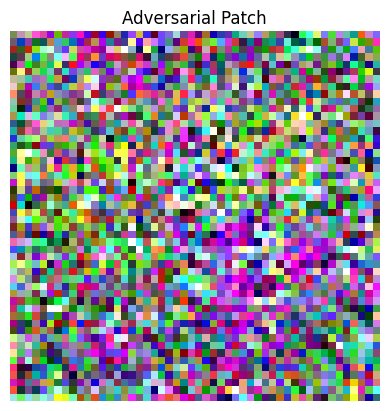

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the adversarial patch from the .pt file
patch = torch.load('adversarial_patch.pt')

# Convert tensor to numpy array and permute dimensions for visualization
# PyTorch uses [C, H, W], convert it to [H, W, C] for Matplotlib
patch_np = patch.detach().cpu().numpy()
patch_np = np.transpose(patch_np, (1, 2, 0))

# Ensure values are in the range [0, 1] for display
patch_np = np.clip(patch_np, 0, 1)

# Display the patch using Matplotlib
plt.imshow(patch_np)
plt.axis('off')  # Turn off axis labels
plt.title('Adversarial Patch')
plt.show()

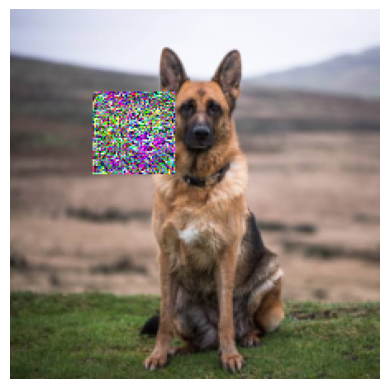

tensor([235])
Predicted label: German Shepherd Dog


In [28]:
# Load the adversarial patch from the .pt file
patch = torch.load('adversarial_patch.pt')

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Visualize the patched image
def visualize_image(image_tensor):
    # Convert tensor to numpy array for visualization
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

# Example usage
image_path = "german_shepard_dog.jpeg"
image = load_image(image_path)

# Apply the adversarial patch at a specific location (e.g., top-left corner)
x_offset, y_offset = 50, 50  # Adjust these values as needed
patched_image = apply_patch(image, patch, (x_offset, y_offset))

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image using the model
output = model(patched_image)
# Step 6: Get the predicted label
_, predicted_idx = torch.max(output, 1)
print(predicted_idx)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label: {predicted_label}")

Step 0, Loss: 1.4441767930984497, Predicted label: German Shepherd Dog
Step 50, Loss: -17.854389190673828, Predicted label: black stork
Step 100, Loss: -33.28532028198242, Predicted label: black stork
Step 150, Loss: -39.14151382446289, Predicted label: black stork
Step 200, Loss: -42.13240432739258, Predicted label: black stork
Step 250, Loss: -43.53750228881836, Predicted label: black stork
Step 300, Loss: -44.905887603759766, Predicted label: black stork
Step 350, Loss: -45.74601364135742, Predicted label: black stork
Step 400, Loss: -46.50555419921875, Predicted label: black stork
Step 450, Loss: -47.492008209228516, Predicted label: black stork
Step 0, Loss: 1.4238330125808716, Predicted label: German Shepherd Dog
Step 50, Loss: -0.37936902046203613, Predicted label: German Shepherd Dog
Step 100, Loss: -0.40370646119117737, Predicted label: German Shepherd Dog
Step 150, Loss: -0.5532522201538086, Predicted label: German Shepherd Dog
Step 200, Loss: -0.622616708278656, Predicted la

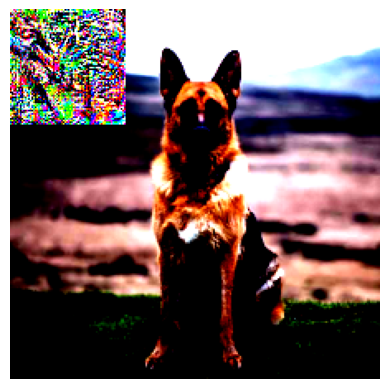

Predicted label after patching: black stork


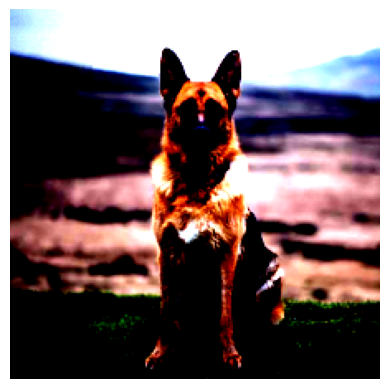

Predicted label after blended patching: German Shepherd Dog


In [30]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Download ImageNet class labels
file_path = "imagenet-simple-labels.json"
with open(file_path, 'r') as json_file:
    labels = json.load(json_file)

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Function to apply and blend patch onto image at a specified location
def apply_blended_patch(image, patch, location, alpha=0.3):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = (
        alpha * patch + (1 - alpha) * patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w]
    )
    return patched_image

# Function to apply patch to an image at a given location
def apply_patch(image, patch, location):
    patched_image = image.clone()
    patched_image[:, :, location[0]:location[0]+patch.size(1), location[1]:location[1]+patch.size(2)] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

# Adversarial training loop
def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.1):
    image = load_image(image_path)
    
    # Initialize random patch with required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch at a fixed location (e.g., top-left corner)
        patched_image = apply_patch(image, patch, (0, 0))
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss to maximize the target class probability
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(output, 1)
            predicted_label = labels[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch
# Adversarial training loop with blending and pixel constraint
def train_subtle_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05, alpha=0.3, epsilon=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply and blend patch at a fixed location
        patched_image = apply_blended_patch(image, patch, (0, 0), alpha=alpha)
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss to maximize the target class probability
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch with pixel constraint
        with torch.no_grad():
            patch.clamp_(-epsilon, epsilon)  # Keep pixel values close to zero to avoid large perturbations
        
        # Step optimizer
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(output, 1)
            predicted_label = labels[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch


# Define the target class and train the patch on an example image
target_class = 128  # Replace with your desired target class index
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image
trained_patch = train_patch(image_path, target_class, patch_size=(70, 70), num_steps=500, lr=0.05)
subtle_patch = train_subtle_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05, alpha=0.3, epsilon=0.05)

# Save the trained subtle adversarial patch
torch.save(subtle_patch, "subtle_adversarial_patch.pt")

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch.pt")

# Reload and apply the adversarial patch for evaluation
image = load_image(image_path)
patched_image = apply_patch(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

patched_blended_image = apply_blended_patch(image, subtle_patch, (0, 0), alpha=0.3)
# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image
output = model(patched_image)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label after patching: {predicted_label}")

visualize_image(patched_blended_image)

output = model(patched_blended_image)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label after blended patching: {predicted_label}")

Step 0, Loss: 1.1949440240859985, Predicted label: German Shepherd Dog
Step 50, Loss: -10.99245548248291, Predicted label: German Shepherd Dog
Step 100, Loss: -14.98956298828125, Predicted label: German Shepherd Dog
Step 150, Loss: -16.594369888305664, Predicted label: black stork
Step 200, Loss: -18.217239379882812, Predicted label: black stork
Step 250, Loss: -21.00206756591797, Predicted label: black stork
Step 300, Loss: -24.36514663696289, Predicted label: black stork
Step 350, Loss: -26.768115997314453, Predicted label: black stork
Step 400, Loss: -29.075176239013672, Predicted label: black stork
Step 450, Loss: -30.847396850585938, Predicted label: black stork


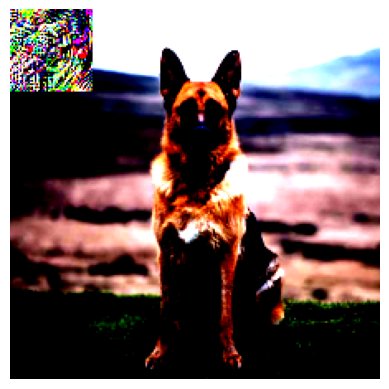

Predicted label after placing patch: black stork


In [31]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Download ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(url) as response:
    labels = json.loads(response.read().decode())

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Overlay patch onto image without modifying the original image
def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

# Adversarial patch training loop
def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch directly without altering the base image
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at the top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss to maximize the target class probability
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(output, 1)
            predicted_label = labels[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch

# Define the target class and train the patch on an example image
target_class = 128  # Replace with your desired target class index
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)
patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image
output = model(patched_image)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label after placing patch: {predicted_label}")


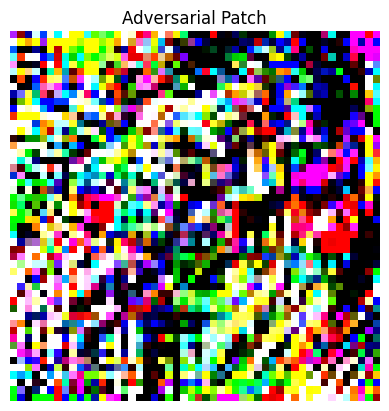

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the adversarial patch from the .pt file
patch = torch.load('adversarial_patch_direct.pt')

# Convert tensor to numpy array and permute dimensions for visualization
# PyTorch uses [C, H, W], convert it to [H, W, C] for Matplotlib
patch_np = patch.detach().cpu().numpy()
patch_np = np.transpose(patch_np, (1, 2, 0))

# Ensure values are in the range [0, 1] for display
patch_np = np.clip(patch_np, 0, 1)

# Display the patch using Matplotlib
plt.imshow(patch_np)
plt.axis('off')  # Turn off axis labels
plt.title('Adversarial Patch')
plt.show()

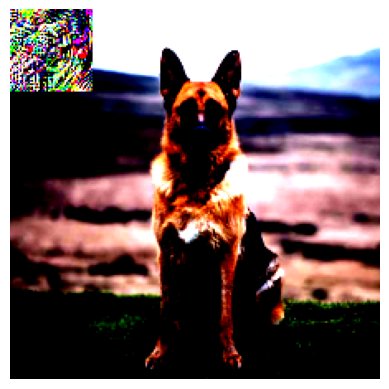

In [37]:
def apply_patch(image, patch, location):
    patched_image = image.clone()
    patched_image[:, :, location[0]:location[0]+patch.size(1), location[1]:location[1]+patch.size(2)] = patch
    return patched_image


# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)
patched_image = apply_patch(image, patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)
